# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [34]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [35]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [36]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-27 09:00:00+09:00,49905.800781,50258.488281,49838.980469,50258.488281,0,0.0,0.0
2025-10-27 09:15:00+09:00,50275.890625,50338.550781,50217.531250,50312.671875,0,0.0,0.0
2025-10-27 09:30:00+09:00,50309.531250,50379.789062,50265.160156,50265.160156,0,0.0,0.0
2025-10-27 09:45:00+09:00,50261.640625,50316.500000,50053.851562,50073.218750,0,0.0,0.0
2025-10-27 10:00:00+09:00,50069.949219,50132.078125,50025.289062,50045.808594,0,0.0,0.0
2025-10-27 10:15:00+09:00,50050.488281,50245.199219,50015.000000,50244.460938,0,0.0,0.0
2025-10-27 10:30:00+09:00,50244.058594,50472.828125,50242.828125,50472.828125,0,0.0,0.0
2025-10-27 10:45:00+09:00,50469.789062,50491.230469,50392.531250,50432.898438,0,0.0,0.0
2025-10-27 11:00:00+09:00,50434.000000,50434.000000,50315.941406,50322.218750,0,0.0,0.0


## 前日終値の取得

In [37]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-20 00:00:00+09:00    49185.500000
2025-10-21 00:00:00+09:00    49316.058594
2025-10-22 00:00:00+09:00    49307.789062
2025-10-23 00:00:00+09:00    48641.609375
2025-10-24 00:00:00+09:00    49299.648438
2025-10-27 00:00:00+09:00    50445.941406
Name: Close, dtype: float64


Date
2025-10-24 00:00:00+09:00    49299.648438
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [38]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+606.15


## ローソク足チャート（小さいサイズ）

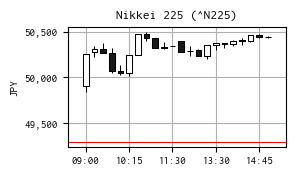

In [39]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [40]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [41]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-24 08:00:00+09:00,152.580002,152.630997,152.557007,152.615005,0,0.0,0.0
2025-10-24 08:15:00+09:00,152.608994,152.630005,152.595001,152.626007,0,0.0,0.0
2025-10-24 08:30:00+09:00,152.613007,152.673996,152.569000,152.574005,0,0.0,0.0
2025-10-24 08:45:00+09:00,152.574997,152.638000,152.567993,152.598007,0,0.0,0.0
2025-10-24 09:00:00+09:00,152.606003,152.613007,152.498993,152.542007,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-27 14:15:00+09:00,153.227997,153.255005,153.207001,153.225998,0,0.0,0.0
2025-10-27 14:30:00+09:00,153.225998,153.244995,153.136993,153.166000,0,0.0,0.0
2025-10-27 14:45:00+09:00,153.166000,153.186005,153.104996,153.123001,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [42]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-27 09:00:00+09:00,325.892019,328.195119,325.455673,328.195119
2025-10-27 09:15:00+09:00,328.531885,328.941343,328.150531,328.772235
2025-10-27 09:30:00+09:00,328.975291,329.434709,328.685147,328.685147
2025-10-27 09:45:00+09:00,328.741643,329.100456,327.382576,327.509249
2025-10-27 10:00:00+09:00,327.822366,328.229141,327.529963,327.664310
2025-10-27 10:15:00+09:00,327.718555,328.993475,327.486186,328.988641
2025-10-27 10:30:00+09:00,328.871891,330.369300,328.863837,330.369300
2025-10-27 10:45:00+09:00,330.226188,330.366480,329.720686,329.984811
2025-10-27 11:00:00+09:00,329.765472,329.765472,328.993539,329.034584


### 前日の終値のドル円レートから、前日の終値のドル換算

In [43]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-24 15:15:00+09:00


np.float64(152.95899963378906)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 322.3062948602703


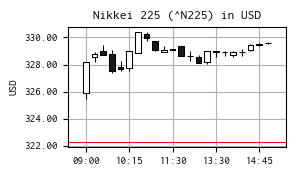

In [44]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()